<a href="https://colab.research.google.com/github/Gaurav1401/Deep-Learning/blob/main/Time_Series_Analysis/Univariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv("sample.csv",index_col="Year")

In [3]:
df.head()

,Number
Year,
1985,"2,309"
1986,"3,447"
1987,"3,708"
1988,"4,443"
1989,"5,840"


In [4]:
df.tail()

,Number
Year,
2017,"15,558"
2018,"14,936"
2019,"17,759"
2020,"15,271"
2021,6425


In [5]:
future = np.array([2022, 2023, 2024, 2025, 2026])

In [6]:
df.shape

(37, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 1985 to 2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  37 non-null     object
dtypes: object(1)
memory usage: 592.0+ bytes


In [8]:
df["Number"] = df["Number"].str.replace(",","")

In [9]:
df["Number"] = df["Number"].astype("int64")

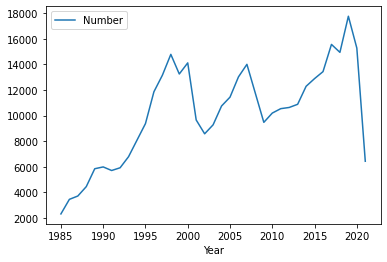

In [10]:
df.plot()

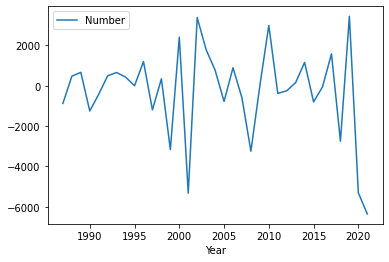

In [11]:
df.diff().diff().plot()

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


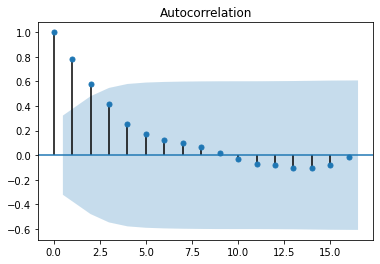

In [13]:
plot_acf(df);

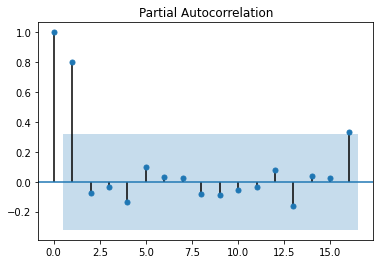

In [14]:
plot_pacf(df);

# train_test_split

In [15]:
df.shape, 37-5

((37, 1), 32)

In [16]:
train = df.iloc[:27]
test = df.iloc[27:]

In [17]:
test.shape

(10, 1)

# Feature Scaling

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Model Creation

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
n_input = 5
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [23]:
len(train_generator), len(val_generator)

(22, 5)

In [24]:
def mape(actual, pred): 
    # actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_vanillaLSTM.h5", verbose = 1, save_best_only = True, save_weights_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00001,verbose = 1, min_delta=0.001)

# Vanilla LSTM

In [30]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

In [31]:
model.fit_generator(train_generator,
                    epochs=50,
                    validation_data = val_generator,
                    callbacks=[reduce_lr , checkpoint])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


22/22 [==============================] - ETA: 0s - loss: 0.3937
Epoch 00001: val_loss improved from inf to 0.62540, saving model to best_vanillaLSTM.h5
22/22 [==============================] - 1s 21ms/step - loss: 0.3937 - val_loss: 0.6254 - lr: 0.0010
Epoch 2/50
21/22 [===========================>..] - ETA: 0s - loss: 0.1952
Epoch 00002: val_loss improved from 0.62540 to 0.23616, saving model to best_vanillaLSTM.h5
22/22 [==============================] - 0s 13ms/step - loss: 0.1866 - val_loss: 0.2362 - lr: 0.0010
Epoch 3/50
20/22 [==========================>...] - ETA: 0s - loss: 0.0611
Epoch 00003: val_loss improved from 0.23616 to 0.13757, saving model to best_vanillaLSTM.h5
22/22 [==============================] - 0s 14ms/step - loss: 0.0566 - val_loss: 0.1376 - lr: 0.0010
Epoch 4/50
21/22 [===========================>..] - ETA: 0s - loss: 0.0406
Epoch 00004: val_loss did not improve from 0.13757
22/22 [==============================] - 0s 13ms/step - loss: 0.0388 - val_loss: 0.14

In [32]:
model.load_weights("/content/best_vanillaLSTM.h5")

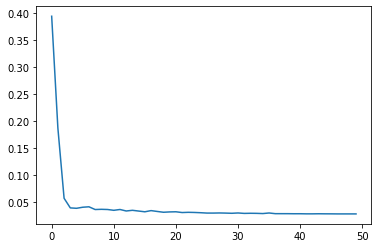

In [33]:
plt.plot(model.history.history["loss"])

# Prediction  on test set

In [34]:
final_batch = np.array(scaled_test[-10:-5])

In [35]:
final_batch = final_batch.reshape((1, n_input, n_features))

In [36]:
model.predict(final_batch)

array([[0.7637768]], dtype=float32)

In [37]:
scaled_test[0]

array([0.66714778])

In [38]:
scaled_test[-5:]

array([[1.06238473],
       [1.01250902],
       [1.23887419],
       [1.03937134],
       [0.33004571]])

In [39]:
def getting_predictions(n_input, n_features, model):
  test_predictions = []

  first_eval_batch = scaled_test[-5:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))
  # print(current_batch.shape)
  for i in range(len(first_eval_batch)):
      
      current_pred = model.predict(current_batch)[0]
      
      test_predictions.append(current_pred) 
      
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

  return test_predictions

In [40]:
test_predictions = getting_predictions(5, 1, model)
test_predictions

[array([0.7972002], dtype=float32),
 array([0.7634754], dtype=float32),
 array([0.7354739], dtype=float32),
 array([0.71434903], dtype=float32),
 array([0.70212144], dtype=float32)]

In [41]:
def plot(scaler, predictions):
  predictions = scaler.inverse_transform(predictions)
  print("Predictions of next five years:- ", predictions)
  plt.figure(figsize = (13,5))
  plt.plot(df.index, df.Number)
  plt.scatter(future, predictions)

Predictions of next five years:-  [[12250.88373089]
 [11830.30193901]
 [11481.09464812]
 [11217.64677119]
 [11065.15643579]]


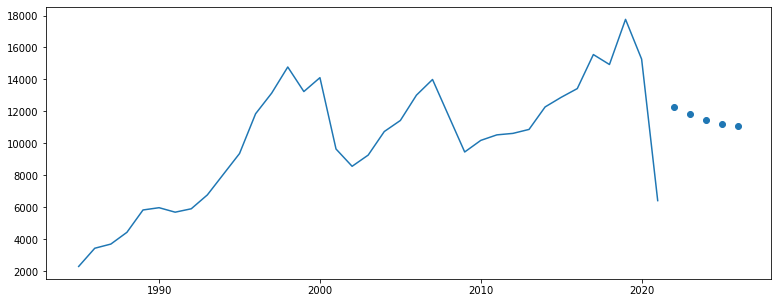

In [42]:
plot(scaler, test_predictions)

# Stacked LSTM

In [43]:
model1 = Sequential()
model1.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features), recurrent_dropout=0.1))
model1.add(LSTM(50, activation='relu', recurrent_dropout=0.1))
model1.add(Dropout(0.3))
# model1.add(Dense(25 , activation='elu'))
# model1.add(Dropout(0.3))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

In [44]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_stackedLSTM.h5", verbose = 1, save_best_only = True, save_weights_only=True)

In [45]:
model1.fit_generator(train_generator,
                    epochs=50,
                    validation_data = val_generator,
                    callbacks=[reduce_lr , checkpoint])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


21/22 [===========================>..] - ETA: 0s - loss: 0.3469
Epoch 00001: val_loss improved from inf to 0.55535, saving model to best_stackedLSTM.h5
22/22 [==============================] - 4s 58ms/step - loss: 0.3599 - val_loss: 0.5553 - lr: 0.0010
Epoch 2/50
21/22 [===========================>..] - ETA: 0s - loss: 0.1065
Epoch 00002: val_loss improved from 0.55535 to 0.20506, saving model to best_stackedLSTM.h5
22/22 [==============================] - 1s 41ms/step - loss: 0.1225 - val_loss: 0.2051 - lr: 0.0010
Epoch 3/50
21/22 [===========================>..] - ETA: 0s - loss: 0.0539
Epoch 00003: val_loss improved from 0.20506 to 0.19151, saving model to best_stackedLSTM.h5
22/22 [==============================] - 1s 40ms/step - loss: 0.0582 - val_loss: 0.1915 - lr: 0.0010
Epoch 4/50
21/22 [===========================>..] - ETA: 0s - loss: 0.0609
Epoch 00004: val_loss improved from 0.19151 to 0.15833, saving model to best_stackedLSTM.h5
22/22 [==============================] - 1s 

In [46]:
model1.load_weights("/content/best_stackedLSTM.h5")

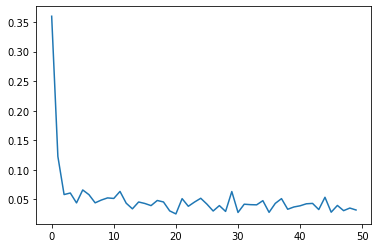

In [47]:
plt.plot(model1.history.history["loss"])

In [48]:
model1.predict(scaled_test[-5:].reshape((1, n_input, n_features)))

array([[0.9090821]], dtype=float32)

In [49]:
test_predictions = getting_predictions(5, 1, model1)
test_predictions

[array([0.9090821], dtype=float32),
 array([0.87067425], dtype=float32),
 array([0.8451255], dtype=float32),
 array([0.7959099], dtype=float32),
 array([0.77020246], dtype=float32)]

Predictions of next five years:-  [[13646.16305238]
 [13167.17860305]
 [12848.56006545]
 [12234.79213333]
 [11914.19485253]]


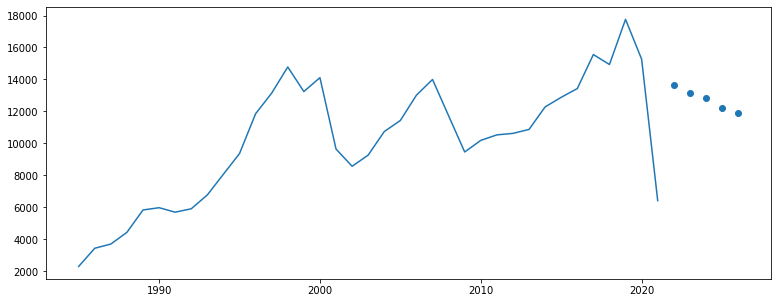

In [50]:
plot(scaler, test_predictions)

# Bidirectional LSTM

In [51]:
model2 = Sequential()

model2.add(Bidirectional(LSTM(100 ,return_sequences=True , recurrent_dropout=0.1, input_shape=(n_input, n_features))))
model2.add(LSTM(50 ,recurrent_dropout=0.1))
model2.add(Dropout(0.3))
# model2.add(Dense(25 , activation='elu'))
# model2.add(Dropout(0.3))
model2.add(Dense(12 , activation='elu'))
model2.add(Dense(1 , activation='linear'))

In [52]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.002)
model2.compile(loss='mse', optimizer=optimizer)

In [53]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_bidirectionalLSTM.h5", verbose = 1, save_best_only = True, save_weights_only=True)

In [54]:
model2.fit(train_generator,
          epochs=50,
          validation_data = val_generator,
          callbacks=[reduce_lr , checkpoint])

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.3552
Epoch 00001: val_loss improved from inf to 0.66395, saving model to best_bidirectionalLSTM.h5
22/22 [==============================] - 7s 85ms/step - loss: 0.3552 - val_loss: 0.6640 - lr: 0.0020
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.2138
Epoch 00002: val_loss improved from 0.66395 to 0.48394, saving model to best_bidirectionalLSTM.h5
22/22 [==============================] - 1s 62ms/step - loss: 0.2138 - val_loss: 0.4839 - lr: 0.0020
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.1325
Epoch 00003: val_loss improved from 0.48394 to 0.37570, saving model to best_bidirectionalLSTM.h5
22/22 [==============================] - 1s 60ms/step - loss: 0.1325 - val_loss: 0.3757 - lr: 0.0020
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.0876
Epoch 00004: val_loss improved from 0.37570 to 0.30881, saving model to best_bidirectionalLSTM.h5
22/22 [==

In [55]:
model2.load_weights("/content/best_bidirectionalLSTM.h5")

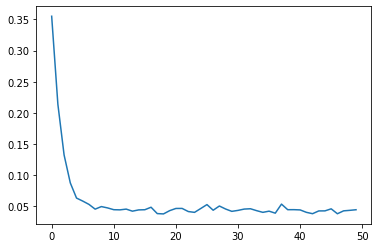

In [56]:
plt.plot(model2.history.history["loss"])

In [57]:
test_predictions = getting_predictions(5, 1, model2)
test_predictions

[array([0.6840599], dtype=float32),
 array([0.67750305], dtype=float32),
 array([0.6717713], dtype=float32),
 array([0.66404456], dtype=float32),
 array([0.65958345], dtype=float32)]

Predictions of next five years:-  [[10839.91123646]
 [10758.14052874]
 [10686.65973163]
 [10590.29969531]
 [10534.66519701]]


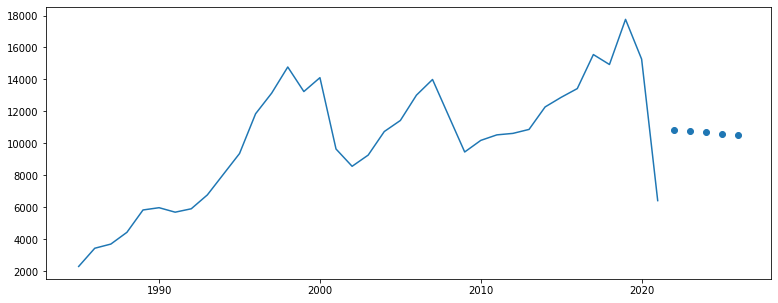

In [58]:
plot(scaler, test_predictions)